In [1]:
import collections, math, os, sys
sys.path.insert(0, '../../../../FISH-annotation/Annotation')
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation
from sklearn.neighbors import KDTree
import util
import pandas as pd
import matplotlib.pyplot as plt

# Recall vs. NND
Recall vs. NND. Each marker represents one NND bin.

In [8]:
middle_bins = [(x, y) for x, y in zip(range(3, 13, 2), range(5, 15, 2)) ] 
nnd_bins = [(0, 3)] + middle_bins + [(15, 30)]

In [3]:
density_list = [0.0025, 0.0027, 0.003, 0.0037, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
clustering_params = ['AffinityPropagation', -350]
correctness_threshold = 4
declumping_params = ['KMeans', 2]
height = 300
cwd = os.getcwd()

In [14]:
json_paths = [cwd + '/anno/Fig2B.json',
              cwd + '/anno/Fig2B_inv.json']

num_spots_detected_list = [0]*len(nnd_bins)
num_spots_total_list = [0]*len(nnd_bins)
detection_lists = []

# for each file
for json_path in json_paths:
    detection_list = []
    
    # for each image
    for density in density_list:
        print(density)
        
        if(json_path == json_paths[0]):
            img_name = 'snr_9_1_density_' + str(density) + '_spot_img.png'
            img_path = cwd + '/spot_images/og/' + img_name
        else:
            img_name = 'snr_9_1_density_' + str(density) + '_spot_img_inv.png'
            img_path = cwd + '/spot_images/inv/' + img_name
        
        csv_path = cwd + '/spot_data/' + 'snr_9_1_density_' + str(density) + '_coord_snr_list.csv'
        
        """ Get cluster centroids """
        qa = QuantiusAnnotation(json_path, img_name)
        anno_all = qa.df()
        sa = SpotAnnotationAnalysis(qa)

        clusters = sa.get_clusters(anno_all, clustering_params)
        cluster_size_threshold = util.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
        clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        result_clusters = nonclumpy_clusters
        for i in range(len(clumpy_clusters.index)):
            subclusters = util.declump(clumpy_clusters, i, declumping_params)
            result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

        """ Count up num_spots_detected, num_spots_total at each SNR """
        result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
        result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')
        
        ref_df = pd.read_csv(csv_path)
        ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
        ref_kdt = KDTree(ref_points, leaf_size=2, metric='euclidean')

        # for each bin
        for index in range(len(nnd_bins)):
            low, high = nnd_bins[index]
            num_total = 0
            num_detected = 0

            # for each spot in the image
            for ref_point in ref_points:
                dist, ind = ref_kdt.query([ref_point], k=2)
                ref_nnd = dist[0][1]

                # if the spot's is in the SNR bin
                if (ref_nnd > low) and (ref_nnd <= high):
                    num_total += 1
                    dist, ind = result_kdt.query([[ref_point[0], height-ref_point[1]]], k=1)
                    if dist[0][0] <= correctness_threshold:
                        num_detected += 1
            num_spots_total_list[index] += num_total    
            num_spots_detected_list[index] += num_detected

    detection_list = [d/t for d, t in zip(num_spots_detected_list, num_spots_total_list)]
    detection_lists.append(detection_list)
    
print(detection_lists)

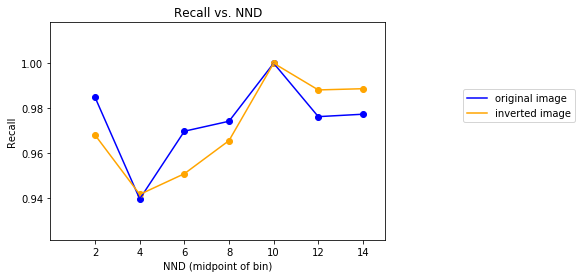

In [13]:
from matplotlib.lines import Line2D

nnd_list = range(2, 16, 2)
plt.scatter(nnd_list, detection_lists[0], color='blue')
plt.plot(nnd_list, detection_lists[0], color='blue')
plt.scatter(nnd_list, detection_lists[1], color='orange')
plt.plot(nnd_list, detection_lists[1], color='orange')

e1 = Line2D([0],[0], color='blue', label='original image')
e2 = Line2D([0],[0], color='orange', label='inverted image')
plt.legend(handles=[e1, e2], loc=9, bbox_to_anchor=(1.4, 0.715))

plt.xticks(range(2, 16, 2))
plt.xlim(0, 15)
plt.xlabel('NND (midpoint of bin)')
plt.ylabel('Recall')
plt.title('Recall vs. NND')
plt.show()